## Summary
Reconstructing Treasury Bond Index returns is possible for longer maturity (>1Y) with correlations close to 1.
Shorter maturities replication is not as successful.

In [115]:
import yfinance as yf
import pandas_datareader as pdr
import datetime
import pandas as pd
import financialtool
import numpy as np

In [82]:
# TBIL 3M UTEN 10Y UTWO 2Y XBIL 6M
CONFIG_TABLE = pd.DataFrame({
    'Name': ['US Treasury 3 Month Bill ETF', 'US Treasury 6 Month Bill ETF', 'US Treasury 2 Year Note ETF', 'US Treasury 5 Year Note ETF', 'US Treasury 10 Year Note ETF'],
    'Ticker': ['TBIL', 'XBIL', 'UTWO', 'UFIV', 'UTEN'],
    'Tenor': ['3M', '6M', '2Y', '5Y', '10Y'],
    'Duration': [3/12, 6/12, 2, 5, 10],
    'RatesTicker': ['^IRX', np.nan, np.nan, '^FVX', '^TNX']
})

In [92]:
# Get yield data from FRED
yield_data = financialtool.rates.get_yield_historical_data(tenors=CONFIG_TABLE['Tenor'].to_list())
yield_data = yield_data.div(100)

In [87]:
# Get Yield Data From Yahoo
yield_data_yf = yf.download(CONFIG_TABLE['RatesTicker'].dropna().to_list())
yield_data_yf = yield_data_yf['Adj Close'].div(100)
yield_data_yf.columns = CONFIG_TABLE.set_index('RatesTicker').loc[yield_data_yf.columns.to_list()]['Tenor']

[*********************100%%**********************]  3 of 3 completed


In [93]:
# Get ETF Returns
etf_returns = yf.download(CONFIG_TABLE['Ticker'].to_list())['Adj Close'].pct_change()

[*********************100%%**********************]  5 of 5 completed


In [94]:
def reconstruct_bond_returns_from_yield(rates_ts, duration):
    rates_ts_lag = rates_ts.shift()
    days_count = pd.Series(rates_ts.index, rates_ts.index).diff().apply(lambda x: x.days)
    rates_ts_diff = rates_ts.diff()
    bond_returns = rates_ts_lag.mul(days_count).div(365).add(
        rates_ts_diff.mul(duration).mul(-1)
    )
    return bond_returns

,Name,Ticker,Duration,RatesTicker,Correlation
Tenor,,,,,
3M,US Treasury 3 Month Bill ETF,TBIL,0.25,^IRX,0.059812
6M,US Treasury 6 Month Bill ETF,XBIL,0.50,NaN,0.464475
2Y,US Treasury 2 Year Note ETF,UTWO,2.00,NaN,0.954638
5Y,US Treasury 5 Year Note ETF,UFIV,5.00,^FVX,0.879057
10Y,US Treasury 10 Year Note ETF,UTEN,10.00,^TNX,0.972739


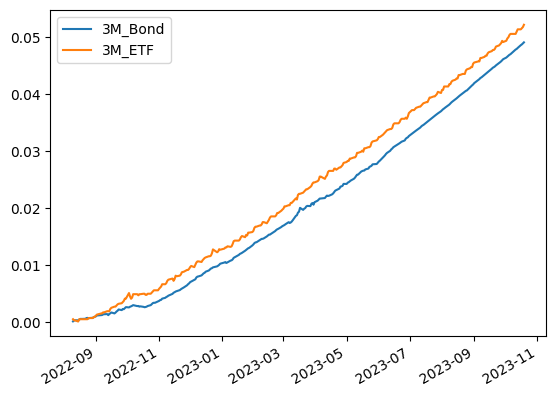

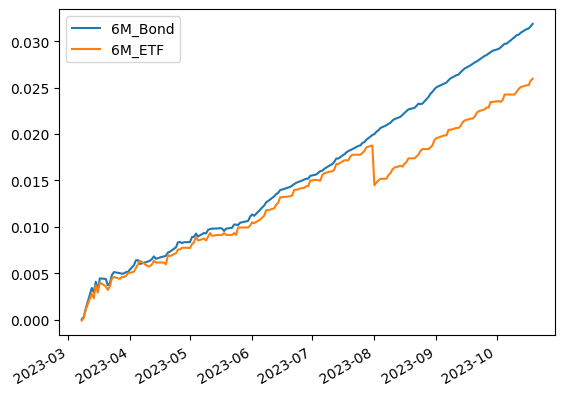

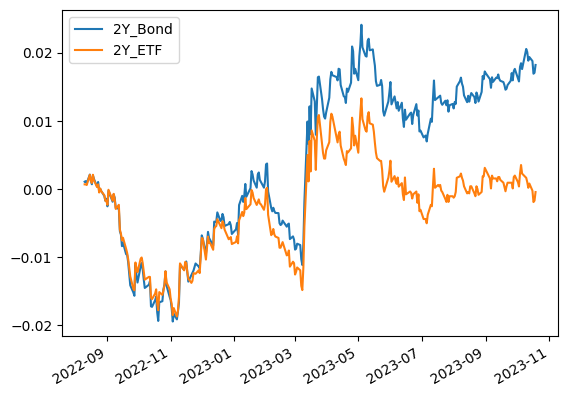

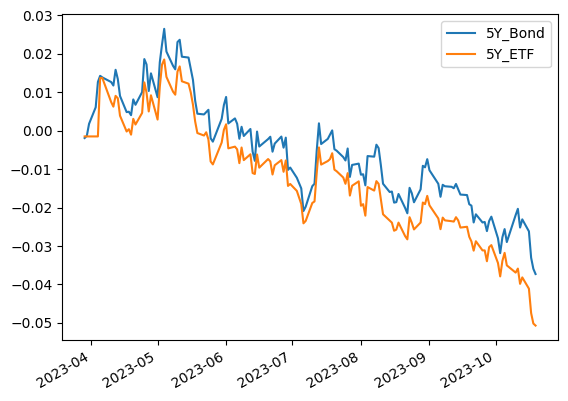

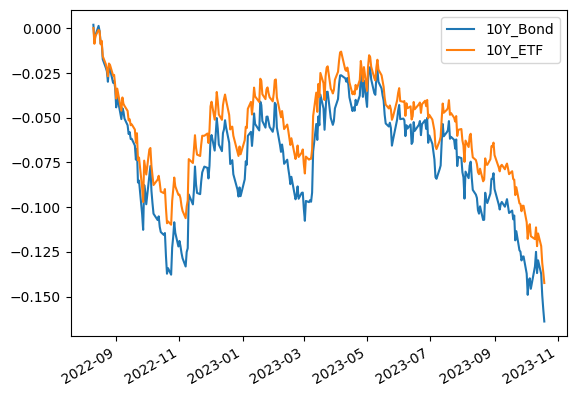

In [107]:
# Construct returns
reconstructed_metrics = pd.DataFrame()
reconstructed_metrics.index = CONFIG_TABLE['Tenor']
for row_i, row in CONFIG_TABLE.iterrows():
    _ticker = row['Ticker']
    _tenor = row['Tenor']
    _duration = row['Duration']
    _yield_data = yield_data[_tenor]
    _yield_data = _yield_data.dropna()

    _bond_returns = reconstruct_bond_returns_from_yield(_yield_data, _duration)
    _correlation = _bond_returns.corr(etf_returns[_ticker])
    pd.concat([_bond_returns.to_frame(f'{_tenor}_Bond'), etf_returns[_ticker].to_frame(f'{_tenor}_ETF')], axis=1).dropna().cumsum().plot(legend=True)
    reconstructed_metrics.loc[_tenor, 'Correlation'] = _correlation

CONFIG_TABLE.set_index('Tenor').join(reconstructed_metrics)

,Name,Ticker,Duration,RatesTicker,Correlation
Tenor,,,,,
3M,US Treasury 3 Month Bill ETF,TBIL,0.25,^IRX,0.133619
6M,US Treasury 6 Month Bill ETF,XBIL,0.50,NaN,NaN
2Y,US Treasury 2 Year Note ETF,UTWO,2.00,NaN,NaN
5Y,US Treasury 5 Year Note ETF,UFIV,5.00,^FVX,0.861915
10Y,US Treasury 10 Year Note ETF,UTEN,10.00,^TNX,0.958217


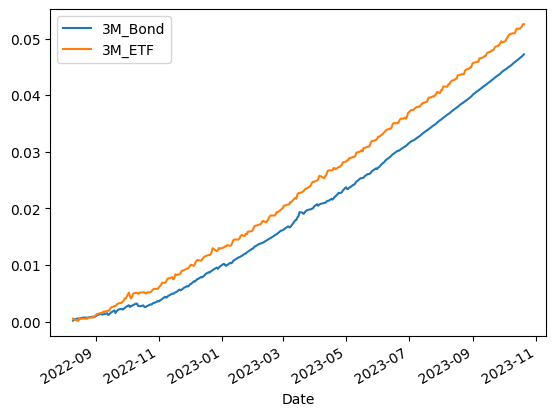

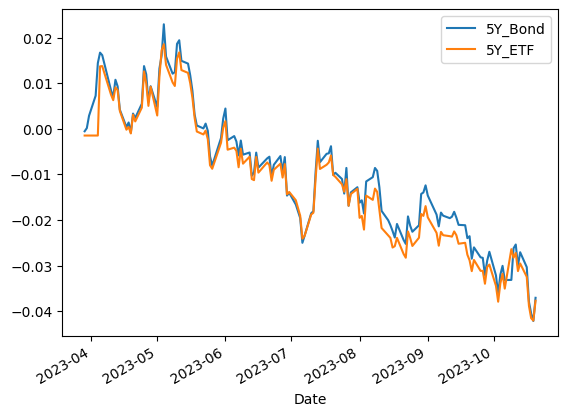

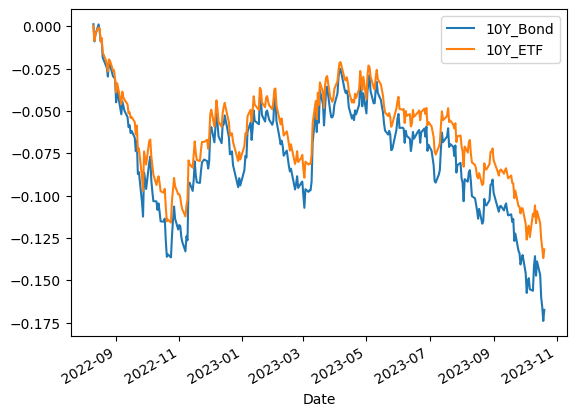

In [108]:
# Alternative Source of Rates

# Construct returns
reconstructed_metrics = pd.DataFrame()
reconstructed_metrics.index = CONFIG_TABLE['Tenor']
for row_i, row in CONFIG_TABLE.iterrows():
    if row['RatesTicker'] is not np.nan:
        _ticker = row['Ticker']
        _tenor = row['Tenor']
        _duration = row['Duration']
        _yield_data = yield_data_yf[_tenor]
        _yield_data = _yield_data.dropna()
    
        _bond_returns = reconstruct_bond_returns_from_yield(_yield_data, _duration)
        _correlation = _bond_returns.corr(etf_returns[_ticker])
        reconstructed_metrics.loc[_tenor, 'Correlation'] = _correlation
        pd.concat([_bond_returns.to_frame(f'{_tenor}_Bond'), etf_returns[_ticker].to_frame(f'{_tenor}_ETF')], axis=1).dropna().cumsum().plot(legend=True)

CONFIG_TABLE.set_index('Tenor').join(reconstructed_metrics)

<Axes: >

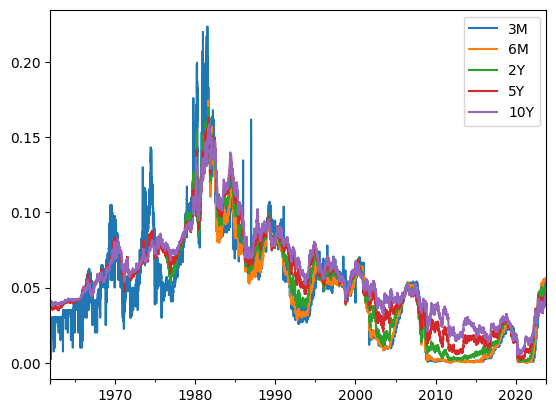

In [124]:
fedfundsrate = pdr.get_data_fred('DFF', datetime.datetime(1900, 1, 1))
yield_data_ff = yield_data.copy()
yield_data_ff['3M'] = fedfundsrate.div(100)
yield_data_ff.plot()

,Name,Ticker,Duration,RatesTicker,Correlation
Tenor,,,,,
3M,US Treasury 3 Month Bill ETF,TBIL,0.25,^IRX,-0.024728
6M,US Treasury 6 Month Bill ETF,XBIL,0.50,NaN,0.464475
2Y,US Treasury 2 Year Note ETF,UTWO,2.00,NaN,0.954638
5Y,US Treasury 5 Year Note ETF,UFIV,5.00,^FVX,0.879057
10Y,US Treasury 10 Year Note ETF,UTEN,10.00,^TNX,0.972739


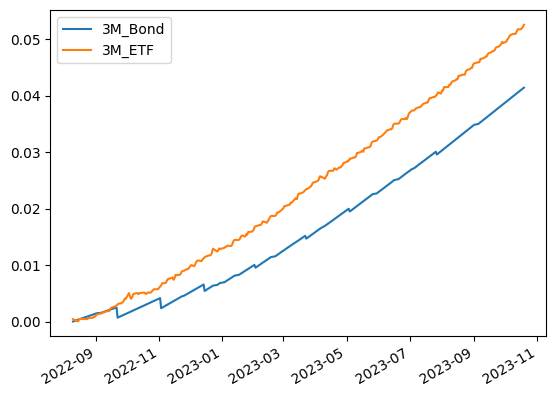

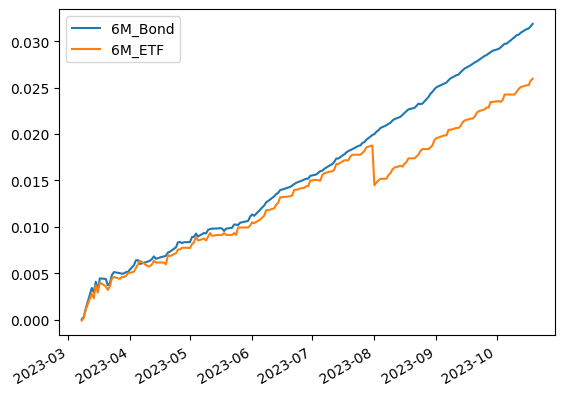

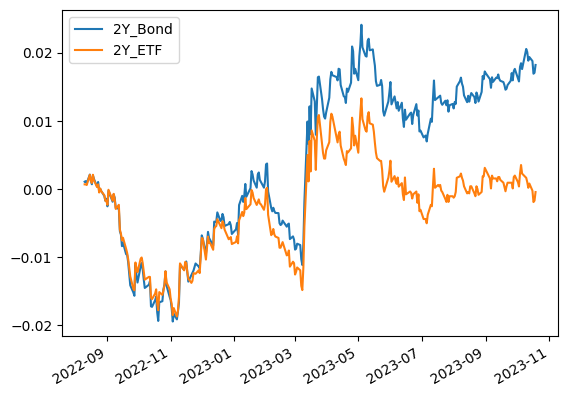

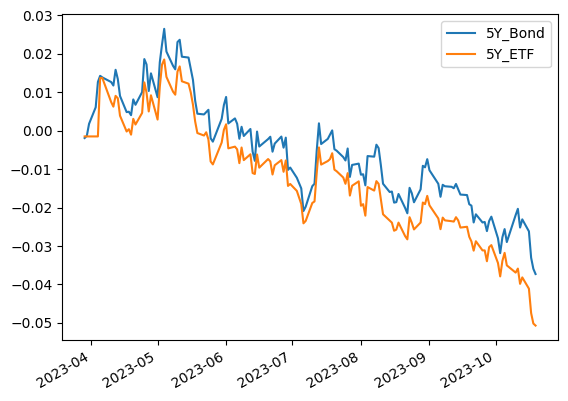

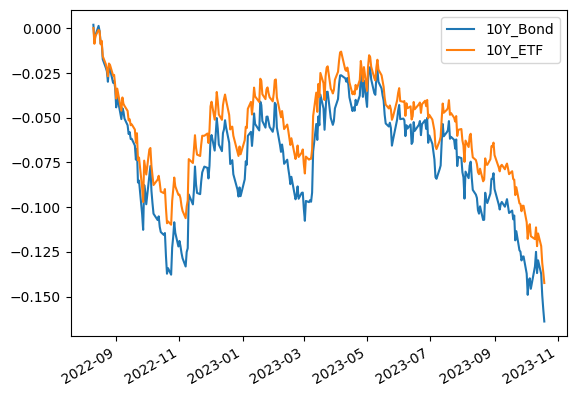

In [123]:
# Construct returns
reconstructed_metrics = pd.DataFrame()
reconstructed_metrics.index = CONFIG_TABLE['Tenor']
for row_i, row in CONFIG_TABLE.iterrows():
    _ticker = row['Ticker']
    _tenor = row['Tenor']
    _duration = row['Duration']
    _yield_data = yield_data_ff[_tenor]
    _yield_data = _yield_data.dropna()

    _bond_returns = reconstruct_bond_returns_from_yield(_yield_data, _duration)
    _correlation = _bond_returns.corr(etf_returns[_ticker])
    pd.concat([_bond_returns.to_frame(f'{_tenor}_Bond'), etf_returns[_ticker].to_frame(f'{_tenor}_ETF')], axis=1).dropna().cumsum().plot(legend=True)
    reconstructed_metrics.loc[_tenor, 'Correlation'] = _correlation

CONFIG_TABLE.set_index('Tenor').join(reconstructed_metrics)